In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import os
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# download dataset from https://www.kaggle.com/datasets/shaorrran/coco-wikiart-nst-dataset-512-100000
#!pip install split-folders
#import splitfolders
#splitfolders.ratio("folder_name", output="output", seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

In [2]:
# Use cuda if available, otherwise cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# ----- Feature Maps ----- #
# (20) relu 4_1
# (29) relu 5_1
# ----- Loss Encoder ----- #
# (2) relu 1_1
# (6) relu 2_1
# (11) relu 3_1
# (20) relu 4_1
# (29) relu 5_1
vgg = torch.hub.load("pytorch/vision:v0.10.0", "vgg19", weights="VGG19_Weights.IMAGENET1K_V1")
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

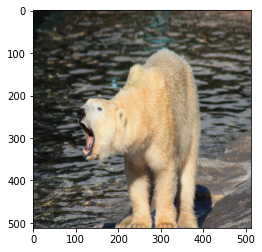

In [5]:
### Load datasets
images = Image.open("output/train/content/000000000013.jpg")
plt.imshow(images);

In [6]:
class ContentStyleDataset(Dataset):
    def __init__(self, root_dir, transform=None, shuffle=True):
        content = glob.glob(os.path.join(root_dir, "content/*"))
        style = glob.glob(os.path.join(root_dir, "style/*"))
        if shuffle:
            np.random.shuffle(content)
            np.random.shuffle(style)
        self.glob_list = np.array(list(zip(content, style)))
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.glob_list)
    
    def __getitem__(self, idx):
        content_img = self.transform(Image.open(self.glob_list[idx, 0]))
        style_img = self.transform(Image.open(self.glob_list[idx, 1]))
        return (content_img, style_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


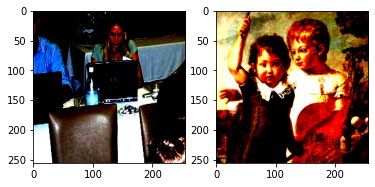

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomCrop(256),
])

cs_dataset = ContentStyleDataset('output/train', transform=preprocess)
for content, style in cs_dataset:
    print(content.size(), style.size())
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(content.unsqueeze(0)[0].permute(1, 2, 0))
    ax[1].imshow(style.unsqueeze(0)[0].permute(1, 2, 0))
    break

In [8]:
### Helper functions

def normalize(x):
    # Channel-wise mean-variance normalization
    x_std, x_mn = torch.std_mean(x, dim=(-1, -2), keepdim=True)
    return torch.nan_to_num((x - x_mn) / x_std)     # broadcast to image dim


def feature_extractor(encoder, trainable=False):
    # Returns designated feature maps for pretrained vgg19
    return_nodes = {
        "features.1": "relu1_1",
        "features.6": "relu2_1",
        "features.11": "relu3_1",
        "features.20": "relu4_1",
        "features.29": "relu5_1"
    }
    extractor = create_feature_extractor(encoder, return_nodes=return_nodes)
    if not trainable:
        for p in extractor.parameters():
            p._requires_grad = False
    return extractor

# pretrained decoder from Github user https://github.com/GlebSBrykin/SANET
def pretrained_decoder(in_channel=512, out_channel=3, decoder_path="decoder_iter_500000.pth", trainable=False):
    decoder = nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(in_channel, 256, kernel_size=3),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, kernel_size=3),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, kernel_size=3),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, out_channel, kernel_size=3),
    )
    decoder.load_state_dict(torch.load(decoder_path))
    if not trainable:
        for p in decoder.parameters():
            p._requires_grad = False
    return decoder

In [9]:
class SANet(nn.Module):
    def __init__(self, in_channels):
        super(SANet, self).__init__()
        # Learnable weights
        self.conv_c1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_s1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_s2 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, f_c, f_s):
        # Set up attention for f_c and f_s
        f_c_hat, f_s_hat = normalize(f_c), normalize(f_s)
        f = self.conv_c1(f_c_hat)
        g = self.conv_s1(f_s_hat)
        attention = F.softmax(torch.matmul(f, g.transpose(-2, -1)), dim=-1)   # infer fixed dim 1 & 2
        h = self.conv_s2(f_s_hat)
        value = torch.matmul(attention, h)   # infer fixed dim 1 & 2
        return value

In [10]:
# Decoder module if not using pretrained decoder
class Decoder(nn.Module):
    def __init__(self, in_channels=512, out_channels=3):
        super(Decoder, self).__init__()
        # Learnable decode layers
        self.conv_1 = nn.Conv2d(in_channels, 256, kernel_size=3)
        self.conv_2 = nn.Conv2d(256, 256, kernel_size=3)
        self.conv_3 = nn.Conv2d(256, 256, kernel_size=3)
        self.conv_4 = nn.Conv2d(256, 256, kernel_size=3)
        self.conv_5 = nn.Conv2d(256, 128, kernel_size=3)
        self.conv_6 = nn.Conv2d(128, 128, kernel_size=3)
        self.conv_7 = nn.Conv2d(128, 64, kernel_size=3)
        self.conv_8 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv_9 = nn.Conv2d(64, out_channels, kernel_size=3)
    
    def forward(self, i):
        i = F.relu(self.conv_1(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.interpolate(i, scale_factor=2)
        i = F.relu(self.conv_2(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.relu(self.conv_3(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.relu(self.conv_4(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.relu(self.conv_5(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.interpolate(i, scale_factor=2)
        i = F.relu(self.conv_6(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.relu(self.conv_7(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = F.interpolate(i, scale_factor=2)
        i = F.relu(self.conv_8(F.pad(i, pad=(1,1,1,1), mode='reflect')))
        i = self.conv_9(F.pad(i, pad=(1,1,1,1), mode='reflect'))
        return i

In [11]:
class SANTransfer(nn.Module):
    def __init__(self, feature_map, img_channels=3, hidden_channels=512, train_decoder=False):
        super(SANTransfer, self).__init__()
        # Feature mapping
        self.encode = feature_map
        self.decode = pretrained_decoder(hidden_channels, img_channels, trainable=train_decoder)
        # Output construction
        self.sanet_r4 = SANet(hidden_channels)
        self.sanet_r5 = SANet(hidden_channels)
        self.conv_r4_csc = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1)
        self.conv_r5_csc = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1)
        self.conv_m_csc = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)

    def transfer(self, i_c, i_s):
        # Encode
        with torch.no_grad():
            e_c, e_s = self.encode(i_c), self.encode(i_s)
        # SANet r4_1
        f_r4_c, f_r4_s = e_c['relu4_1'], e_s['relu4_1']
        f_r4 = self.sanet_r4(f_r4_c, f_r4_s)
        f_r4_csc = f_r4_c + self.conv_r4_csc(f_r4)
        # SANet r5_1
        f_r5_c, f_r5_s = e_c['relu5_1'], e_s['relu5_1']
        f_r5 = self.sanet_r5(f_r5_c, f_r5_s)
        f_r5_csc = f_r5_c + self.conv_r5_csc(f_r5)
        # Raw output
        f_m_csc = self.conv_m_csc(f_r4_csc + F.interpolate(f_r5_csc, scale_factor=2))
        # Decode
        i_cs = self.decode(f_m_csc)
        return i_cs

    def get_identity(self, i_c, i_s):
        return (self.transfer(i_c, i_c), self.transfer(i_s, i_s))

    def forward(self, i_c, i_s):
        return self.transfer(i_c, i_s)

In [12]:
class STLoss(nn.Module):
    def __init__(self, feature_map, lmbda_c=1, lmbda_s=3, lmbda_i1=50, lmbda_i2=1):
        super(STLoss, self).__init__()
        self.feature_map = feature_map
        self.lmbda_c = lmbda_c
        self.lmbda_s = lmbda_s
        self.lmbda_i1 = lmbda_i1
        self.lmbda_i2 = lmbda_i2

    def forward(self, output, content, style, content_identity, style_identity):
        with torch.no_grad():
            output_map = self.feature_map(output)
            content_map = self.feature_map(content)
            style_map = self.feature_map(style)
            content_identity_map = self.feature_map(content_identity)
            style_identity_map = self.feature_map(style_identity)
        
        # Content loss
        content_loss = torch.linalg.norm(normalize(output_map['relu4_1']) - normalize(content_map['relu4_1']))\
              + torch.linalg.norm(normalize(output_map['relu5_1']) - normalize(content_map['relu5_1']))

        # Style loss
        style_loss = 0.
        for layer in output_map.keys():
            # Mean/Variance (AdaIn) loss
            style_loss += torch.linalg.norm(torch.mean(output_map[layer], dim=(-1, -2, -3)) - 
                                            torch.mean(style_map[layer], dim=(-1, -2, -3)))\
                    + torch.linalg.norm(torch.std(output_map[layer], dim=(-1, -2, -3)) - 
                                        torch.std(style_map[layer], dim=(-1, -2, -3)))

        # Identity loss
        i1_loss = torch.linalg.norm(content_identity - content) + torch.linalg.norm(style_identity - style)
        i2_loss = 0.
        for layer in output_map.keys():
            # Per layer feature loss
            i2_loss += torch.linalg.norm(content_identity_map[layer] - content_map[layer])\
                + torch.linalg.norm(style_identity_map[layer] - style_map[layer])
        identity_loss = self.lmbda_i1 * i1_loss + self.lmbda_i2 * i2_loss
        
        # Total Loss
        return self.lmbda_c * content_loss + self.lmbda_s * style_loss + identity_loss

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.RandomCrop(256),
])
test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
])

cs_train = ContentStyleDataset('output/train', transform=train_transform)
cs_test = ContentStyleDataset('output/val', transform=test_transform)
len(cs_train)

39984

In [14]:
train_loader = DataLoader(cs_train, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(cs_test, batch_size=5, shuffle=True)
len(train_loader)

7996

In [15]:
load_path = "save_state/st_model_state_6_ep.tar"
epochs = 9

In [16]:
### Training
feature_map = feature_extractor(vgg)
st_model = SANTransfer(feature_map, train_decoder=True).to(device)
loss_func = STLoss(feature_map)
optimizer = torch.optim.Adam(st_model.parameters(), lr=1e-4)
start_epoch = 0
train_loss, val_loss = torch.zeros(epochs), torch.zeros(epochs)

if load_path:
    checkpoint = torch.load(load_path)
    st_model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    cp_train_loss, cp_val_loss = checkpoint["loss"]
    for i in range(len(cp_train_loss)):
        train_loss[i] = cp_train_loss[i]
        val_loss[i] = cp_val_loss[i]

for epoch in range(start_epoch, epochs):
    start_time = time.time()
    st_model.train()
    batch_loss = []
    i = 0
    for content, style in train_loader:
        content, style = content.to(device), style.to(device)

        output = st_model(content, style)
        content_identity, style_identity = st_model.get_identity(content, style)
        t_loss = loss_func(output, content, style, content_identity, style_identity)

        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()

        batch_loss.append(t_loss.item())
        i += 1
        if i%500==0:
            print("Batch", i, "Loss:", t_loss.item())

    train_loss[epoch] = np.mean(batch_loss)
    
    st_model.eval()
    batch_loss = []
    for content, style in test_loader:
        content, style = content.to(device), style.to(device)

        with torch.no_grad():
            output = st_model(content, style)
            content_identity, style_identity = st_model.get_identity(content, style)
            v_loss = loss_func(output, content, style, content_identity, style_identity)
        batch_loss.append(v_loss.item())
    
    val_loss[epoch] = np.mean(batch_loss)
    
    print(f"Epoch {epoch+1}/{epochs} ({(time.time()-start_time):0.1f}s): "\
           f"train loss - {train_loss[epoch]:0.2f}, validation loss - {val_loss[epoch]:0.2f}")


Batch 500 Loss: 25250.5
Batch 1000 Loss: 23728.9765625
Batch 1500 Loss: 30186.115234375
Batch 2000 Loss: 25258.080078125
Batch 2500 Loss: 24343.435546875
Batch 3000 Loss: 25205.875
Batch 3500 Loss: 22741.201171875
Batch 4000 Loss: 21506.421875
Batch 4500 Loss: 24102.60546875
Batch 5000 Loss: 25528.07421875
Batch 5500 Loss: 25864.61328125
Batch 6000 Loss: 21975.0078125
Batch 6500 Loss: 30757.564453125
Batch 7000 Loss: 30745.9765625
Batch 7500 Loss: 23296.0234375
Epoch 4/6 (9422.7s): train loss - 25771.75, validation loss - 51452.62
Batch 500 Loss: 25362.884765625
Batch 1000 Loss: 24849.978515625
Batch 1500 Loss: 26780.21484375
Batch 2000 Loss: 24078.82421875
Batch 2500 Loss: 25533.0859375
Batch 3000 Loss: 26466.974609375
Batch 3500 Loss: 25577.986328125
Batch 4000 Loss: 24934.25390625
Batch 4500 Loss: 28863.62109375
Batch 5000 Loss: 26152.03515625
Batch 5500 Loss: 25600.236328125
Batch 6000 Loss: 26015.43359375
Batch 6500 Loss: 24292.884765625
Batch 7000 Loss: 24564.8046875
Batch 7500 L

In [17]:
save_path = "save_state/st_model_state_9_ep.tar"
torch.save({
    "epoch": epochs,
    "model_state_dict": st_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": (train_loss, val_loss),
}, save_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


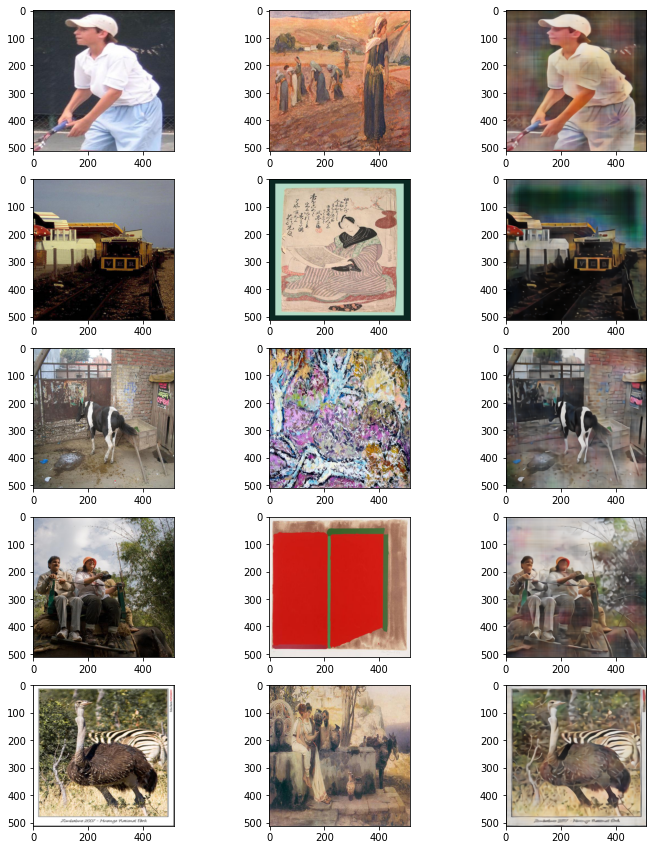

In [19]:
st_model = SANTransfer(feature_map).to("cpu")
state = torch.load(save_path)
st_model.load_state_dict(state["model_state_dict"])
st_model.eval()
for content, style in test_loader:
    fig, ax = plt.subplots(5, 3, figsize=(12, 15))
    output = st_model(content, style).detach()
    for i in range(5):
        ax[i][0].imshow(content[i].cpu().permute(1, 2, 0))
        ax[i][1].imshow(style[i].cpu().permute(1, 2, 0))
        ax[i][2].imshow(output[i].permute(1, 2, 0))
    break
